# 混合密度ネットワーク

混合密度ネットワーク(MDN)(Bishop, 1994) は畳み込みニューラルネットワークと混合密度モデルを組み合わせることで実現されるモデルです。

ここではEdwardを用いた例を示します。原文は[こちら](http://edwardlib.org/tutorials/mixture-density-network)にあります。

# Data

In [ ]:
MDNについて説明した[David Haのブログ記事](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)と同じデータを用います。
これはそれぞれの入力$x_n$から複数の出力$y_n$から推測する逆問題です。

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/apple/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Size of features in training data: (3750, 1)
Size of output in training data: (3750,)
Size of features in test data: (1250, 1)
Size of output in test data: (1250,)


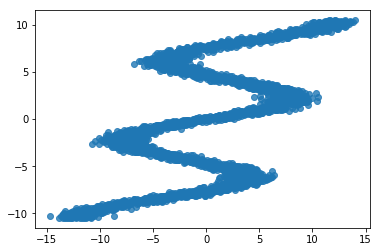

In [2]:
import edward as ed
import numpy as np
import tensorflow as tf

import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

def build_toy_dataset(N):
  y_data = np.random.uniform(-10.5, 10.5, N)
  r_data = np.random.normal(size=N)  # random noise
  x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
  x_data = x_data.reshape((N, 1))
  return train_test_split(x_data, y_data, random_state=42)

N = 5000  # number of data points
D = 1  # number of features

X_train, X_test, y_train, y_test = build_toy_dataset(N)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

sns.regplot(X_train, y_train, fit_reg=False)


Tensorflowのplaceholderを定義しました。これはす移植処理の間データのバッチを取り入れるのに使われます。
これはEdward がmodelにdataを取り入れれるための方法のうちの一つです。

In [3]:
X_ph = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])

# Model

ネットワークによりパラメータが決定された20個の正規分布の混合を使います。これは所属する確率

In [ ]:
from edward.models import Categorical, Mixture, Normal

def neural_network(X):
  """loc, scale, logits = NN(x; theta)"""
  # 2 hidden layers with 15 hidden units
  net = tf.layers.dense(X, 15, activation=tf.nn.relu)
  net = tf.layers.dense(net, 15, activation=tf.nn.relu)
  locs = tf.layers.dense(net, K, activation=None)
  scales = tf.layers.dense(net, K, activation=tf.exp)
  logits = tf.layers.dense(net, K, activation=None)
  return locs, scales, logits

K = 20  # number of mixture components

locs, scales, logits = neural_network(X_ph)
cat = Categorical(logits=logits)
components = [Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs)),
                     tf.unstack(tf.transpose(scales)))]
y = Mixture(cat=cat, components=components, value=tf.zeros_like(y_ph))